 # langkah-langkah
 ---
 * preparing the library

* download the dataset

* Filtering the dataset

* Image augmentation

* Visualize

* Building the model

1. Image Augmentation

2. Rescaling Images

3. Convolutional2D

4. BatchNormalization

5. Activation Layer

## Peringatan!
----
Tips trik menggunakan Colab agar tidak cepat crash

1. Jangan menggunakan batch yang terlalu besar dalam processing, apalagi image

2. Gunakan Precision Policy untuk mempercepat

3.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from tensorflow import data as tf_data

In [ ]:
# Installing the dataset
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  77.7M      0  0:00:10  0:00:10 --:--:-- 78.4M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls # melihat isi dari dataset yang ada

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [ ]:
!ls PetImages/

Cat  Dog


#### Langkah Pertama yaitu memfilter semua gambar yang korup dan gambar yang jelek.
---


In [ ]:
# menggunakan Looping dalam memfilter dataset yang rusak
num_Skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try :
      fobj = open(fpath, "rb")
      is_jfif = b"JFIF" in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_Skipped += 1
      # Delete Corrupted Image
      os.remove(fpath)

print(f'Deleted {num_Skipped} images.')

Deleted 1590 images.


#### Kemudian kita membuat datasetnya dan membaginya
---

In [ ]:
image_size = (180, 180)
batch_size = 32

# Menggunakan utils image_dataset_from_directory
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=84,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


#### Jangan lupa untuk visualisasi
---

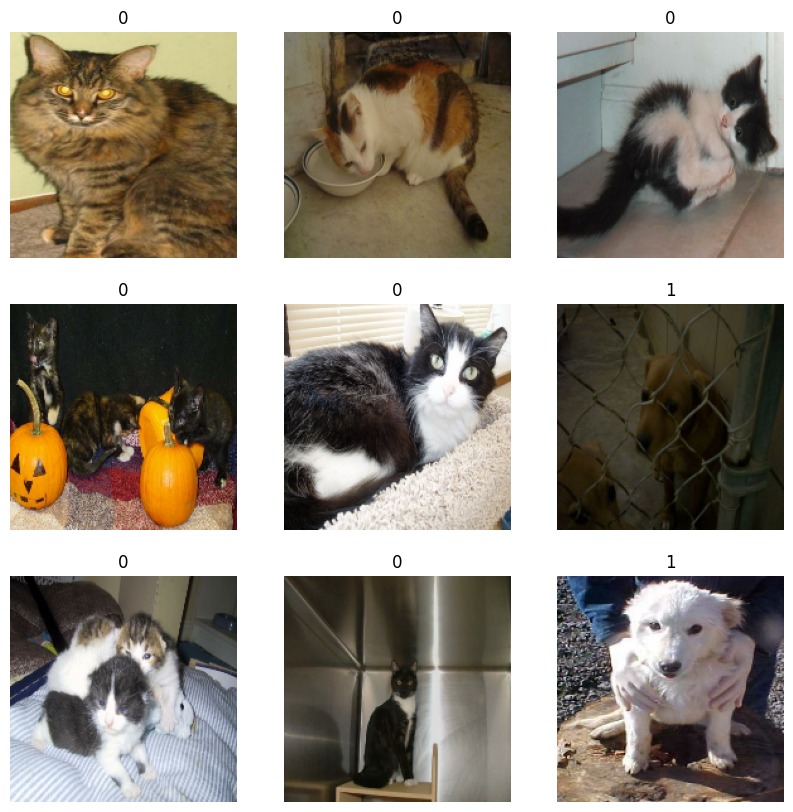

In [ ]:
# Mengecek kesesuaian dataset yang diperlukan
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis('off')

#### Performing data augmentation
---

In [ ]:
# Membuat augmentasi dataset menggunakan variable layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
]

# Membuat fungsi untuk looping gambar terhadap layer.
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

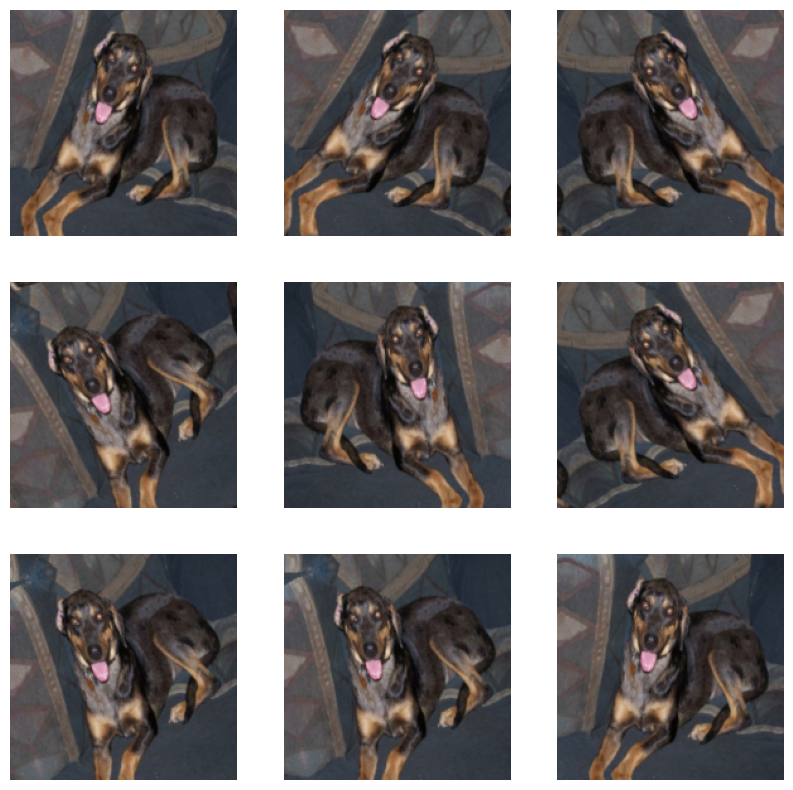

In [ ]:
# Plotting gambar yang sudah diberikan augmentasi
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype('uint8'))
    plt.axis('off')

### Standardizing the dataset
---

#### Konfigurasi dataset untuk performa
---

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

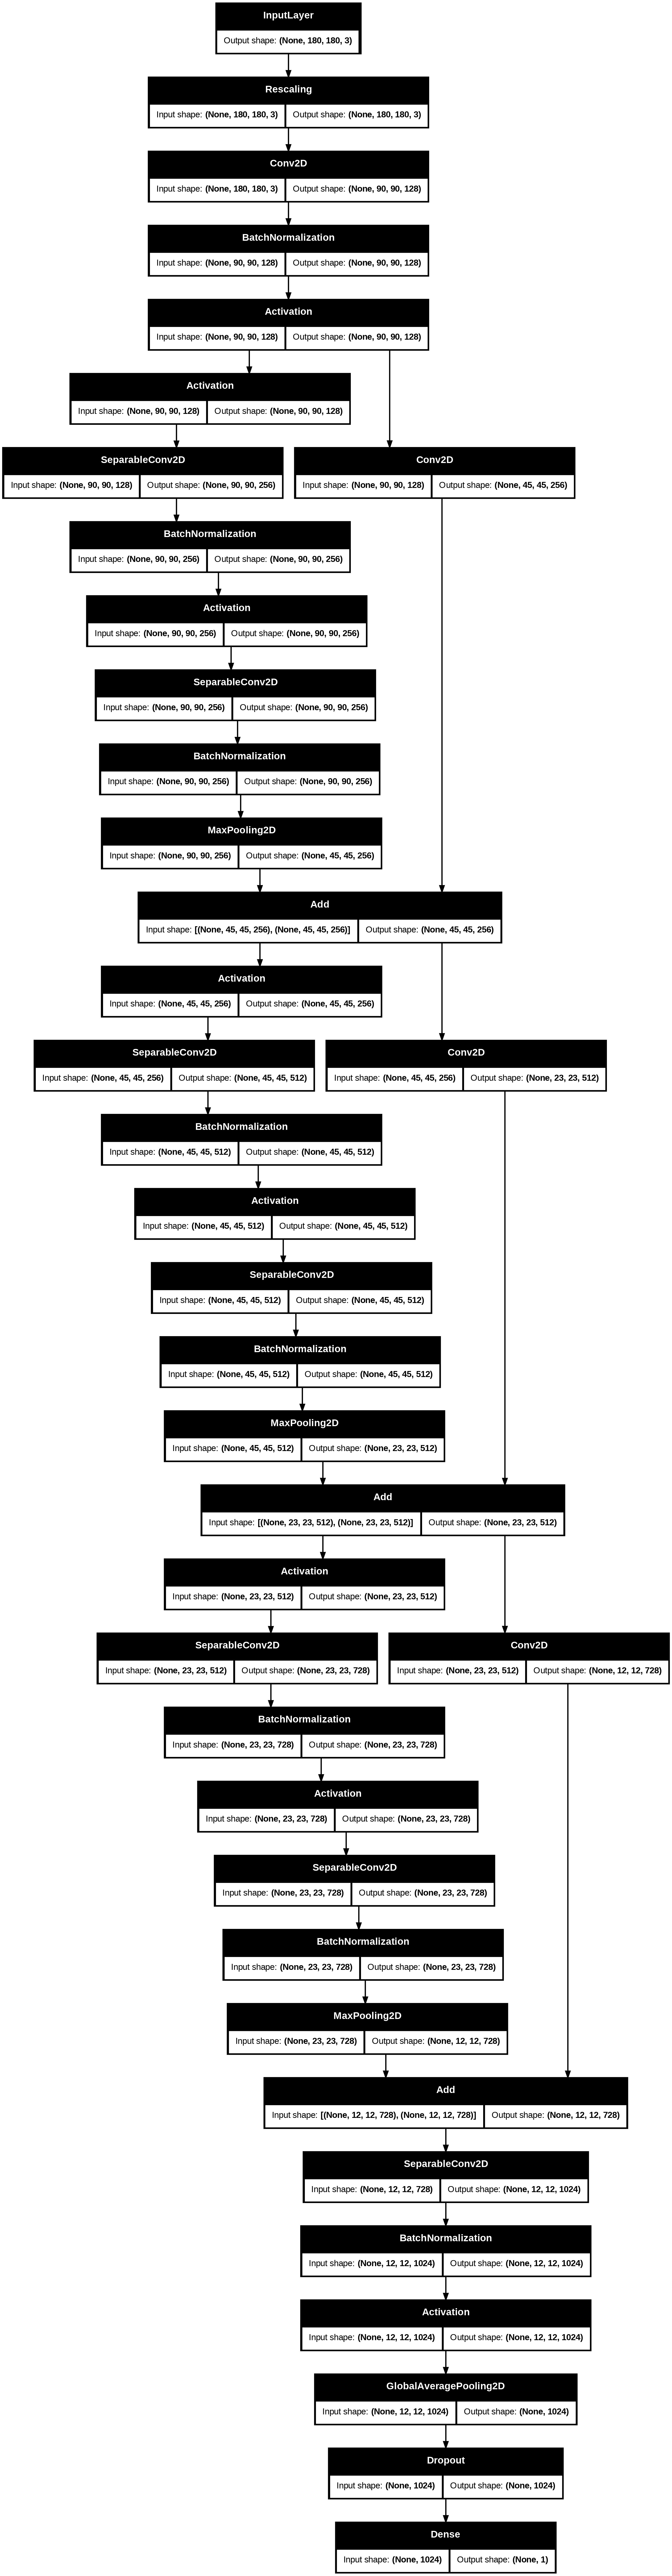

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  '''
  Menggunakan augmentasi data, kemudian melakukan rescaling.
  Setelah itu melakukan Rescaling dan Proses konvolusi.
  Dan melakukan batch normalization untuk menstabilkan aktivasi
  dari tiap output layer.
  Dan proses aktivasi untuk memasukkan non-linearitas dalam model.

  '''
  x = data_augmentation(inputs)
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x

  for size in [256, 512, 728]: # Diulang 3 kali dengan output filter yang berbeda
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    '''
     Projects Residual with Convolutional Layer
     Proyeksi residual untuk menyamakan semua dimensi.
     dari blok aktivasi yang sebelumnya bisa jadi berbeda,
     jadi disamakan dengan blok residual yang baru.

     tidak hanya dimensi spasial(tinggi dan lebar), juga dimensi kedalaman.
     Kemudian setelah disamakan kita masukkan dengan 'layer.add()'
     Kembali ke blok residual sebelumnya.
     Dan menentukan kelas output, jika ada 2 kelas maka hanya 1 output.

    '''
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )

    x = layers.add([x, residual])
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    units = 1
  else:
    units = num_classes

  x = layers.Dropout(0.25)(x)
  # Activation = None for returning logits
  outputs = layers.Dense(units, activation=None)(x)
  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 180, 180, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 90, 90, 128)    │          3,584 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 90, 90, 128)    │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 90, 90, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 90, 90, 128)    │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 90, 90, 256)    │         34,176 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 90, 90, 256)    │          1,024 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 90, 90, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 90, 90, 256)    │         68,096 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 90, 90, 256)    │          1,024 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 45, 45, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 45, 45, 256)    │         33,024 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 45, 45, 256)    │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 45, 45, 256)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 45, 45, 512)    │        133,888 │ activation_3[0][0]     │
│ (SeparableConv2D)    

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.shape)
  print("Label shape: ", label.shape)

Image shape:  (32, 180, 180, 3)
Label shape:  (32,)


In [ ]:
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
train_ds = train_ds.repeat()

val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
epochs = 25

# Setting the callbacks for the model.
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

# Compiling the model.
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Training the model.
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/25


#### Perform inference on new data
---

In [ ]:
img = keras.utils.load_data("PetImages/Cat/6778.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This Image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")